# Botswana BMTHS 2015/16

## Calculate and visualize average food consumption across Nigeria
The data below is from the Nigeria General Household Survey - Wave 3 (2015-2016). It's [available](http://microdata.worldbank.org/index.php/catalog/2936/datafile/F11) on the WB Microdata Library.

With household survey data, sample weights are important to generalize from the sample to the population.

- **Objective: Calculate and visualize average food consumption across Nigeria's regions**

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
import pylab as plt
%pylab inline
import seaborn as sns
import mplleaflet as mpll
import osmnx as ox
from IPython.display import Image
import matplotlib.pyplot as plt2

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


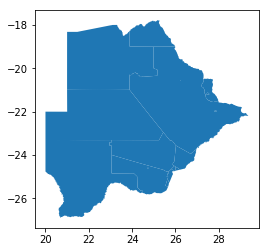

In [3]:
botswana_GADM = gpd.read_file('data/botswana/gadm36_BWA_1.shp')
botswana_GADM.plot()

In [4]:
# List Botswana regions on GADM
botswana_GADM['NAME_1'].value_counts()

Central          1
Sowa             1
North-West       1
Southern         1
Selibe Phikwe    1
Chobe            1
Jwaneng          1
Kweneng          1
North-East       1
Ghanzi           1
Kgalagadi        1
Francistown      1
South-East       1
Kgatleng         1
Lobatse          1
Gaborone         1
Name: NAME_1, dtype: int64

In [5]:
df_bwa = pd.read_csv('data/botswana/LaborForce.csv')
df_bwa['district'].value_counts()

Gaborone             1451
Kweneng East         1256
Central Serowe        776
Central Tutume        608
Francistown           548
Central Mahalapye     511
South East            507
Kgatleng              484
Ngwaketse             477
Ngamiland East        469
Central Bobonong      300
Selibe Phikwe         272
Central Boteti        250
North East            240
Ngamiland West        240
Kweneng West          235
Barolong              214
Ghanzi                180
Lobatse               153
Chobe                 152
Kgalagadi South       130
Kgalagadi North       114
Jwaneng               106
Orapa                  75
Sowa Town              71
Ngwaketse West         50
Name: district, dtype: int64

In [6]:
df_bwa.head()

,age,ind1,occp,district,hhsize_i,Employed,Labour_Force,poorm,freqweight2,workingage,youth,unemp
0,32,Not Stated,Not stated,Gaborone,3,1,1,not poor,80,working age,Youth,0
1,24,"Wholesale & Retail Trade, Repair of Motor Veh...",Service/Sales Workers,Gaborone,4,1,1,below poverty line,80,working age,Youth,0
2,38,Households as Employers,Elementary Occupations,Gaborone,3,1,1,not poor,80,working age,Non-youth,0
3,26,NaN,NaN,Gaborone,4,0,1,not poor,80,working age,Youth,unemployed
4,41,Construction of Buildings,Clerical Support Services,Gaborone,2,1,1,not poor,82,working age,Non-youth,0


In [7]:
df_bwa.rename(columns = {'ind1':'industry','occp':'occupation','hhsize_i':'hhsize',
           'poorm':'poor','freqweight2':'individual_weight', 'unemp':'unemployed', 'Employed':'employed'}, inplace=True)

df_bwa.unemployed.replace({'0': 'not unemployed', 'unemployed':'unemployed'}, inplace=True)
df_bwa.poor.replace({'below poverty line': 'poor', 'not poor':'not poor'}, inplace=True)

df_bwa.district.replace({'North East':'North-East', 'Orapa':'Central', 'Barolong':'Southern', 'Kweneng East':'Kweneng', 'Kweneng West':'Kweneng', 'Central Serowe':'Central', 'Central Tutume':'Central', 'Central Bobonong':'Central', 'Central Boteti':'Central',
       'Central Mahalapye':'Central', 'South East':'South-East', 'Sowa Town':'Sowa', 'Ngwaketse West':'Southern', 'Ngwaketse':'Southern', 
                         'Ngamiland West':'North-West', 'Ngamiland East':'North-West', 'Kgalagadi South':'Kgalagadi', 'Kgalagadi North':'Kgalagadi'}, inplace = True)

In [8]:
df_bwa.head()

,age,industry,occupation,district,hhsize,employed,Labour_Force,poor,individual_weight,workingage,youth,unemployed
0,32,Not Stated,Not stated,Gaborone,3,1,1,not poor,80,working age,Youth,not unemployed
1,24,"Wholesale & Retail Trade, Repair of Motor Veh...",Service/Sales Workers,Gaborone,4,1,1,poor,80,working age,Youth,not unemployed
2,38,Households as Employers,Elementary Occupations,Gaborone,3,1,1,not poor,80,working age,Non-youth,not unemployed
3,26,NaN,NaN,Gaborone,4,0,1,not poor,80,working age,Youth,unemployed
4,41,Construction of Buildings,Clerical Support Services,Gaborone,2,1,1,not poor,82,working age,Non-youth,not unemployed


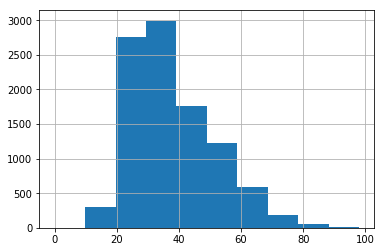

In [9]:
df_bwa.age.hist()

In [10]:
print(df_bwa.age.mean())
print(df_bwa.hhsize.mean())

37.85540581619212
4.5001519910831895


In [11]:
df_bwa.groupby(['district'])['hhsize'].mean()

district
Central          4.886111
Chobe            3.901316
Francistown      4.036496
Gaborone         3.626465
Ghanzi           4.016667
Jwaneng          3.443396
Kgalagadi        3.860656
Kgatleng         4.485537
Kweneng          4.782696
Lobatse          3.516340
North-East       3.945833
North-West       5.875882
Selibe Phikwe    3.669118
South-East       4.704142
Southern         4.592443
Sowa             3.704225
Name: hhsize, dtype: float64

In [12]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [13]:
weighted_means_table = pd.Series({district: weighted_mean(df_bwa.hhsize[df_bwa.district == district],
                                  df_bwa.individual_weight[df_bwa.district == district]) for district in df_bwa.district.unique()},
                                name = 'mean_hhsize')

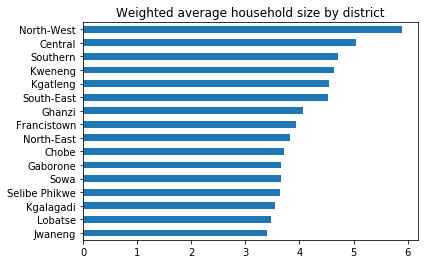

In [14]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Weighted average household size by district');

In [73]:
botswana_GADM['NAME_1'].value_counts()

North-West       1
Francistown      1
Southern         1
Kweneng          1
Central          1
South-East       1
Ghanzi           1
Kgatleng         1
Lobatse          1
Jwaneng          1
Selibe Phikwe    1
Chobe            1
Gaborone         1
Sowa             1
North-East       1
Kgalagadi        1
Name: NAME_1, dtype: int64

In [74]:
Selibe_Phikwe = ['Selibe Phikwe']
Central = ['Central']
Chobe = ['Chobe']
Francistown = ['Francistown']
Gaborone = ['Gaborone']
North_West = ['North-West']
North_East = ['North-East']
South_East = ['South-East']
Southern = ['Southern']
Kweneng = ['Kweneng']
Ghanzi = ['Ghanzi']
Kgatleng = ['Kgatleng']
Lobatse = ['Lobatse']
Jwaneng = ['Jwaneng']
Sowa = ['Sowa']
Kgalagadi = ['Kgalagadi']


def remap_bstates(state):
    if state in Central:
        return('Central')
    elif state in Chobe:
        return('Chobe')
    elif state in Francistown:
        return('Francistown')
    elif state in Gaborone:
        return('Gaborone')
    elif state in South_East:
        return('South-East')
    elif state in Jwaneng:
        return('Jwaneng')
    elif state in Ghanzi:
        return('Ghanzi')
    elif state in Kgalagadi:
        return('Kgalagadi')
    elif state in Kweneng:
        return('Kweneng')
    elif state in Kgatleng:
        return('Kgatleng')
    elif state in Lobatse:
        return('Lobatse')
    elif state in North_East:
        return('North-East')
    elif state in North_West:
        return('North-West')
    elif state in Selibe_Phikwe:
        return('Selibe Phikwe')
    elif state in Sowa:
        return('Sowa')
    elif state in Southern:
        return('Southern')
    else:
        return('error!')

In [75]:
botswana_GADM['region'] = botswana_GADM.NAME_1.apply(remap_bstates)

In [76]:
# Create a new geodataframe comprising six merged polygons

regions = botswana_GADM.dissolve(by = 'region')

In [77]:
regions.head() 

,geometry,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
region,,,,,,,,,,,
Central,"POLYGON ((26.95520973 -23.7490406, 26.94750023...",BWA,Botswana,BWA.1_1,Central,Centre|Ngwato|Serowe-Palapye,None,District,District,None,BW.CE
Chobe,"POLYGON ((25.27033234 -17.79890823, 25.2630996...",BWA,Botswana,BWA.2_1,Chobe,None,None,District,District,None,BW.CH
Francistown,"POLYGON ((27.55546951 -21.16741753, 27.5610580...",BWA,Botswana,BWA.3_1,Francistown,None,None,City,City,None,BW.FR
Gaborone,"POLYGON ((25.8102169 -24.64698029, 25.81138992...",BWA,Botswana,BWA.4_1,Gaborone,None,None,City,City,None,BW.GB
Ghanzi,"POLYGON ((19.99999809 -23.30888939, 19.9999980...",BWA,Botswana,BWA.5_1,Ghanzi,Ghantsi,None,District,District,None,BW.GH


In [78]:
# Check the two frames have the same length before merging

regions.shape

(16, 11)

In [79]:
weighted_means_table.shape

(16,)

In [80]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [81]:
regions_merged = gpd.GeoDataFrame(regions_merged)

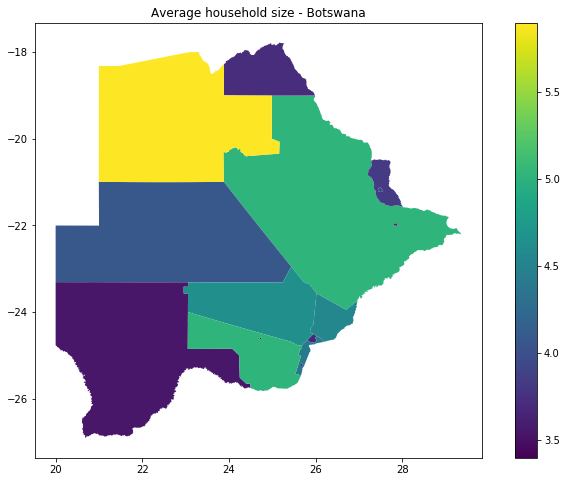

In [82]:
regions_merged.plot(column = 'mean_hhsize', legend = True, figsize = [12,8])
plt.title('Average household size - Botswana');

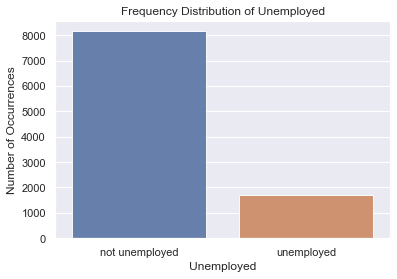

In [84]:
unemployed_count = df_bwa['unemployed'].value_counts()
sns.set(style="darkgrid")
sns.barplot(unemployed_count.index, unemployed_count.values, alpha=0.9)
plt.title('Frequency Distribution of Unemployed')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Unemployed', fontsize=12)
plt.show()

In [89]:
df_bwa_sklearn = df_bwa.copy()

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df_bwa_sklearn['unemployed'] = lb_make.fit_transform(df_bwa['unemployed'])

df_bwa_sklearn.head() #Results in appending a new column to df

,age,industry,occupation,district,hhsize,employed,Labour_Force,poor,individual_weight,workingage,youth,unemployed
0,32,Not Stated,Not stated,Gaborone,3,1,1,not poor,80,working age,Youth,0
1,24,"Wholesale & Retail Trade, Repair of Motor Veh...",Service/Sales Workers,Gaborone,4,1,1,poor,80,working age,Youth,0
2,38,Households as Employers,Elementary Occupations,Gaborone,3,1,1,not poor,80,working age,Non-youth,0
3,26,NaN,NaN,Gaborone,4,0,1,not poor,80,working age,Youth,1
4,41,Construction of Buildings,Clerical Support Services,Gaborone,2,1,1,not poor,82,working age,Non-youth,0


In [91]:
df_bwa_sklearn2 = df_bwa_sklearn.copy()

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df_bwa_sklearn2['poor'] = lb_make.fit_transform(df_bwa_sklearn['poor'])

df_bwa_sklearn2.head() #Results in appending a new column to df

,age,industry,occupation,district,hhsize,employed,Labour_Force,poor,individual_weight,workingage,youth,unemployed
0,32,Not Stated,Not stated,Gaborone,3,1,1,0,80,working age,Youth,0
1,24,"Wholesale & Retail Trade, Repair of Motor Veh...",Service/Sales Workers,Gaborone,4,1,1,1,80,working age,Youth,0
2,38,Households as Employers,Elementary Occupations,Gaborone,3,1,1,0,80,working age,Non-youth,0
3,26,NaN,NaN,Gaborone,4,0,1,0,80,working age,Youth,1
4,41,Construction of Buildings,Clerical Support Services,Gaborone,2,1,1,0,82,working age,Non-youth,0


In [92]:
grouped = df_bwa_sklearn2.groupby(['poor','employed'])
grouped.size()

poor  employed
0     0           1390
      1           7413
1     0            322
      1            744
dtype: int64

In [93]:
pd.crosstab(index=df_bwa_sklearn2["employed"],  # Make a crosstab
                              columns="count") 

col_0,count
employed,
0,1712
1,8157


In [101]:
# create a data frame of unemployed by district and youth 
unemp = pd.crosstab(index=df_bwa_sklearn2["district"], 
                             columns=[df_bwa_sklearn2["unemployed"],
                                      df_bwa_sklearn2["youth"]],
                             margins=True)   # Include row and column totals

unemp

unemployed            0               1         All
youth         Non-youth Youth Non-youth Youth      
district                                           
Central            1234   872       150   314  2570
Chobe                60    77         2    13   152
Francistown         233   233        16    66   548
Gaborone            615   650        37   149  1451
Ghanzi               71    93         8     8   180
Jwaneng              62    37         0     7   106
Kgalagadi           118   105         7    14   244
Kgatleng            220   172        29    63   484
Kweneng             615   589        71   216  1491
Lobatse              81    52         6    14   153
North-East          128    83         9    20   240
North-West          261   241        45   162   709
Selibe Phikwe       111   117        15    29   272
South-East          338   270        29    84   721
Southern            231   126        39    81   477
Sowa                 30    32         2     7    71
All                4408  3749       465  1247  9869

In [105]:
unemp[1] #gives forst table in unemp data frame - those uneemployed

youth,Non-youth,Youth
district,,
Central,150,314
Chobe,2,13
Francistown,16,66
Gaborone,37,149
Ghanzi,8,8
Jwaneng,0,7
Kgalagadi,7,14
Kgatleng,29,63
Kweneng,71,216
